# Project 2: Space Rats
By Rishabh Patel and Eva Allred

Our data and analysis follows our code.

## Code

In [ ]:
import random
import copy
from collections import defaultdict, deque
import numpy as np
import queue
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import heapq
import pickle
import math
import statistics
import imageio
from io import BytesIO
BLOCKED = 0
OPEN = 1
BOT = 2
RAT = 3

In [ ]:
class Ship:
  BOT_START = 0
  RAT_START = 1

  def __init__(self, size, alpha):
    """Creates a ship
    Parameters
    ----------
    size : int
        The size of the ship

    """
    self.size = size
    self.ship = self.make_ship(size)
    self.blocked = set([(i,j) for i in range(size) for j in range(size) if self.ship[i][j]==BLOCKED])
    self.start_locs = self.choose_start_locs()
    self.set_board()
    self.bot_path = []
    self.turn = 0
    self.debug = False
    self.past = {}
    self.sense_past = {}
    self.bot_loc = self.start_locs[self.BOT_START]
    self.rat_loc = self.start_locs[self.RAT_START]
    self.alpha = alpha
    self.num_movements = 0
    self.num_sensing = 0
    self.num_rat_detections = 0
    self.frames = []


  def make_ship(self, size):
    """Generates a grid of open/closed cells to serve as the ship
    Parameters
    ----------
    size : int
        The size of the ship
    Returns
    -------
    ship : list
        A list representing the ship
    """

    ship = [[BLOCKED for _ in range(size)] for i in range(size)]
    borders = set([(0, i) for i in range(size)] + [(size-1, i) for i in range(size)] + [(i, 0) for i in range(size)] + [(i, size-1) for i in range(size)])


    def get_blocked_neighbors(x, y):
      neighbors = set()
      if x < size-2 and ship[x+1][y] == BLOCKED: neighbors.add((x+1, y))
      if x > 1 and ship[x-1][y] == BLOCKED: neighbors.add((x-1, y))
      if y < size-2 and ship[x][y+1] == BLOCKED: neighbors.add((x, y+1))
      if y > 1 and ship[x][y-1] == BLOCKED: neighbors.add((x, y-1))
      return neighbors - borders

    one_neighbor_fringe = set()
    multi_neighbor_cells = set()
    x, y = random.randint(1,size-2), random.randint(1,size-2)
    ship[x][y] = OPEN
    one_neighbor_fringe.update(get_blocked_neighbors(x, y))

    while one_neighbor_fringe:
      x, y = random.choice(list(one_neighbor_fringe))
      ship[x][y] = OPEN
      one_neighbor_fringe.remove((x, y))
      for neighbor in get_blocked_neighbors(x, y):
        if neighbor in one_neighbor_fringe:
          one_neighbor_fringe.remove(neighbor)
          multi_neighbor_cells.add(neighbor)
        else:
          if neighbor not in multi_neighbor_cells: one_neighbor_fringe.add(neighbor)

    #final step
    dead_end_cells = set()
    for i in range(0, size-1):
      for j in range(0, size-1):
        if ship[i][j] == OPEN and len(get_blocked_neighbors(i, j)) == 3:
          dead_end_cells.add((i, j))

    for i, j in dead_end_cells:
      if random.random() < 0.5 and len(get_blocked_neighbors(i, j)) > 1 and (i, j) not in borders:
        closed_neighbor = random.choice(list(get_blocked_neighbors(i, j)))
        ship[closed_neighbor[0]][closed_neighbor[1]] = OPEN

    return ship

  def set_board(self):
    """Places the bot and rat
    """
    self.clear_board()
    self.ship[self.start_locs[self.BOT_START][0]][self.start_locs[self.BOT_START][1]] = BOT
    self.ship[self.start_locs[self.RAT_START][0]][self.start_locs[self.RAT_START][1]] = RAT
    self.bot_loc = self.start_locs[self.BOT_START]
    self.rat_loc = self.start_locs[self.RAT_START]
    self.bot_path = []
    self.turn = 0
    self.num_movements = 0
    self.num_sensing = 0
    self.num_rat_detections = 0
    return

  def choose_start_locs(self):
    """Chooses the starting locations for the bot and rat
    Returns
    -------
    start_locs : list
        A list of the starting locations
    """
    start_locs = random.sample(list(self.get_open_cells()),k=2)
    return start_locs


  def clear_board(self):
    """Returns all non-blocked cells to open
    """
    for i in range(self.size):
      for j in range(self.size):
        if self.ship[i][j] != BLOCKED: self.ship[i][j] = OPEN
        return

  def get_ship(self):
    """Returns the ship
    Returns
    -------
    ship : list
        A list representing the ship
    """
    return self.ship


  def print_layout(self):
    """Prints the ship
    """
    temp = {BLOCKED:'█',OPEN:' ',RAT:'R', BOT:'O'}

    for i in range(self.size):
      print('|',end='')
      for j in range(self.size):
        if self.ship[i][j] == BLOCKED:
          print('█', end='')
          print('|', end='')
          continue
        cell = (i, j)
        if cell == self.bot_loc: print('O', end='')
        elif cell == self.rat_loc: print('R',end='')
        elif cell == self.start_locs[self.BOT_START]: print('□', end='')
        elif cell in self.sense_past: print(self.sense_past[cell], end='')
        else: print(' ', end='')
        print('|', end='')
      print()


  def get_open_cells(self):
    """Returns the open cells in the ship
    Returns
    -------
    open_cells : set
        A set of tuples representing the open cells
    """
    open_cells = set()
    for i in range(self.size):
      for j in range(self.size):
        if self.ship[i][j]==OPEN: open_cells.add((i,j))
    return open_cells

  def get_unblocked_neighbors(self, x, y):
    """Given a cell, finds its unblocked neighbors
    Parameters
    ----------
    x,y : ints
        The coordinates of the cell
    Returns
    -------
    neighbors : set
        A set of the unblocked neighbors of the cell
    """
    neighbors = set()
    if x < self.size-1 and self.ship[x+1][y] != BLOCKED: neighbors.add((x+1, y))
    if x > 0 and self.ship[x-1][y] != BLOCKED: neighbors.add((x-1, y))
    if y < self.size-1 and self.ship[x][y+1] != BLOCKED: neighbors.add((x, y+1))
    if y > 0 and self.ship[x][y-1] != BLOCKED: neighbors.add((x, y-1))
    return neighbors

  def sense_blocked(self,x,y,from_bot):
    if from_bot: self.num_sensing += 1
    num_blocked = 0
    for i in range(x-1,x+2):
      for j in range(y-1,y+2):
        if self.ship[i][j] == BLOCKED: num_blocked+=1
    return num_blocked

  def manhattan_distance(self, cell1, cell2):
    return abs(cell1[0]-cell2[0])+abs(cell1[1]-cell2[1])

  # 0: did not ping, 1: did ping, 2: bot in same square as rat
  def rat_detector(self):
    self.num_rat_detections += 1
    self.sense_past[self.bot_loc] = self.sense_past.get(self.bot_loc, 0)+1
    if self.bot_loc==self.rat_loc: return 2
    prob = math.exp(-self.alpha * (self.manhattan_distance(self.bot_loc,self.rat_loc)-1))
    num = random.random()
    if num <= prob: return 1

    else: return 0

  def move(self,next_step):
    self.num_movements += 1
    x=self.bot_loc[0]+next_step[0]
    y=self.bot_loc[1]+next_step[1]
    if self.ship[x][y]==BLOCKED: return False
    else:
      self.ship[self.bot_loc[0]][self.bot_loc[1]] = OPEN
      self.past[(x, y)]=self.past.get((x, y), 0)+1
      self.bot_loc=(x,y)
      return True

  def get_open_directions(self,x,y):
    # left, top, right, bottom
    l = [0,0,0,0]
    if self.ship[x][y-1] != BLOCKED: l[0]+=1
    if self.ship[x-1][y] != BLOCKED: l[1]+=1
    if self.ship[x][y+1] != BLOCKED: l[2]+=1
    if self.ship[x+1][y] != BLOCKED: l[3]+=1
    return l

  def rat_move(self):
    move = random.choice(list(self.get_unblocked_neighbors(self.rat_loc[0],self.rat_loc[1])))
    self.ship[self.rat_loc[0]][self.rat_loc[1]] = OPEN
    self.rat_loc=move
    self.ship[self.rat_loc[0]][self.rat_loc[1]] = RAT
    return

  # returns where the bot is
  def phase_1(self,rat_moving):
    open_cells = self.get_open_cells()
    open_cells.add(self.bot_loc)
    open_cells.add(self.rat_loc)

    # represents the number of blocked neighbors each cell has
    blocked = {cell:self.sense_blocked(cell[0],cell[1],False) for cell in open_cells}

    # represents what directions are open from each cell using a list [left,top,right,bottom]
    open_directions = {cell:self.get_open_directions(cell[0],cell[1]) for cell in open_cells}

    # the knowledge base is a dictionary with keys being cells the bot could've started
    # from and the values being a list of the path the bot has taken
    kb = {cell:[cell] for cell in open_cells}

    curr_step = 0
    # left, up, right, down
    direction_map={(0,-1):0,(-1,0):1,(0,1):2,(1,0):3}

    # stop once we have determined where the bot is (when there is only one
    # possibility remaining in the knowledge base)
    while len(kb) > 1:
      # determine num blocked cells
      # num_blocked = blocked[self.bot_loc]
      num_blocked = self.sense_blocked(self.bot_loc[0],self.bot_loc[1],True)
      if rat_moving: self.rat_move()
      # self.num_sensing += 1
      # delete cells from kb that don't agree
      to_del = []
      for cell in kb.keys():
        # look at the cell we are hypothetically at
        curr_cell = kb[cell][curr_step]
        # check the number of blocked neighbors, if it doesn't agree, add it to
        # the delete list
        if blocked[curr_cell] != num_blocked: to_del += [cell]

      for cell in to_del:
        kb.pop(cell,None)

      # determine most commonly open direction
      counts = [0,0,0,0]
      for cell in kb.keys():
        curr_cell = kb[cell][curr_step]
        counts = [sum(x) for x in zip(counts,open_directions[curr_cell])]
      # dir is a dictionary containing the total number of counts for each
      # possible direction
      dir = {(0,-1):counts[0],(-1,0):counts[1],(0,1):counts[2],(1,0):counts[3]}
      # idx is the keys of dir sorted by value
      idx = sorted(dir, key=dir.get)
      # the next step is the direction that is most commonly open
      next_step = idx[-1]
      # check if we've already visited, if we have and there's another option,
      # choose that instead
      # look at first key arbitrarily (will be the same for all keys)
      k = list(kb.keys())[0]
      proposed_next_step = (kb[k][curr_step][0] + next_step[0], kb[k][curr_step][1] + next_step[1])
      if proposed_next_step == kb[k][curr_step-1] and dir[idx[-2]] > 0:
        next_step = idx[-2]
      # now attempt to move, moved stores whether or not the move was successful
      moved = self.move(next_step)
      if rat_moving: self.rat_move()

      # update kb with this knowledge:
      to_del = []
      for cell in kb.keys():
        curr_cell = kb[cell][curr_step]
        # delete cell if we failed to move but there was an open cell in the direction we failed to move
        if not moved and open_directions[curr_cell][direction_map[next_step]] == 1:
          to_del += [cell]
        # delete cell if we succeeded in moving but the neighboring cell was closed
        if moved and open_directions[curr_cell][direction_map[next_step]] == 0:
          to_del += [cell]
      for cell in to_del:
        kb.pop(cell,None)

      # update kb with the next cell bot could be in if the bot did move
      if moved:
        for cell in kb.keys():
          next_cell = kb[cell][curr_step]
          if next_step==(0,-1): next_cell = (next_cell[0],next_cell[1]-1)
          elif next_step==(-1,0): next_cell = (next_cell[0]-1,next_cell[1])
          elif next_step==(0,1): next_cell = (next_cell[0],next_cell[1]+1)
          elif next_step==(1,0): next_cell = (next_cell[0]+1,next_cell[1])
          kb[cell] += [next_cell]
        curr_step+=1

      # one round completed
      # repeat!

    # kb has the cell the bot started from and then the path the bot took
    return kb

  def bfs(self, goal):
    q = queue.deque()
    q.appendleft(self.bot_loc)
    prev = {}
    v = set([self.bot_loc])
    prev[self.bot_loc] = None
    while q:
      curr = q.pop()
      if curr == goal:
        return prev
      neighbors = self.get_unblocked_neighbors(curr[0],curr[1])
      for neighbor in neighbors:
        if neighbor in self.blocked or neighbor in v: continue
        prev[neighbor] = curr
        q.appendleft(neighbor)
        v.add(neighbor)
    return None

  def get_first_move(self, finish):
    prev = self.bfs(finish)
    current = finish
    if current is None: return finish
    # when prev[current] == bot_loc we have found the next move!
    while prev[current] != self.bot_loc:
      current = prev[current]
    return current

  def get_prob_xij_given_s(self,rat_moving,kb,cell):
    if not rat_moving: return kb[cell]
    else:
      # base prob
      prob_xij_given_s = 0
      # now, add the probability the bot moves into xij from one of its
      # open neighbors
      for neighbor in self.get_unblocked_neighbors(cell[0],cell[1]):
        k = len(self.get_unblocked_neighbors(neighbor[0],neighbor[1]))
        prob_xij_given_s += ((1/k) * kb[neighbor])
      return prob_xij_given_s

  def update_kb_ping(self, kb, rat_moving, res, gen_viz):
    if not rat_moving: kb[self.bot_loc] = 0
    prob_sensor_true = sum(kb[iter_cell]*math.exp(-self.alpha*(self.manhattan_distance(self.bot_loc, iter_cell))) for iter_cell in kb)
    for cell in kb:
      prob_xij_given_s = kb[cell]
      # if sensor pinged true:
      if res:
        prob_sensor_given_xij = math.exp(-self.alpha*(self.manhattan_distance(self.bot_loc,cell)-1))
        kb[cell] = (prob_xij_given_s * prob_sensor_given_xij)/prob_sensor_true
      else:
        prob_sensor_given_xij = 1 - math.exp(-self.alpha*(self.manhattan_distance(self.bot_loc,cell)-1))
        kb[cell] = (prob_xij_given_s * prob_sensor_given_xij)/(1-prob_sensor_true)

    if gen_viz: self.make_viz(kb)

  def phase_2(self, rat_moving, gen_viz):

    res = self.rat_detector()
    # knowledge base is a dictionary where the keys are the cells and the values
    # are the probability the rat is in that cell
    open_cells = self.get_open_cells()
    open_cells.add(self.bot_loc)
    open_cells.add(self.rat_loc)

    starting_prob = 1/(len(open_cells)-1) # minus 1 because rat can't be in the current bot loc
    kb = {cell:starting_prob for cell in open_cells}
    # need to take care of the case that the bot is already in the rat's cell-> need
    # to rewrite phase1 so that it checks if the bot happens to run into the rat
    kb[self.bot_loc] == 0

    while res != 2:
      if rat_moving: self.rat_move()
      self.update_kb_ping(kb, rat_moving, res, gen_viz)

      # find most likely cell
      most_likely_cell = max(kb, key=kb.get)

      # run bfs to see which direction bot should move in
      # is there a more efficient way to do this?
      if most_likely_cell != self.bot_loc:
        next_move = self.get_first_move(most_likely_cell)
        t = self.move((next_move[0]-self.bot_loc[0],next_move[1]-self.bot_loc[1]))
        if rat_moving:
          self.rat_move()
          self.update_kb_move(kb, gen_viz)
      # now, use the detector
      res = self.rat_detector()

    video_filename = 'ship_visualization.mp4'
    imageio.mimsave(video_filename, self.frames, fps=5)
    return self.bot_loc


  def make_viz(self, kb):
    buf = BytesIO()

    probs = list(kb.values())
    max_prob = max(probs)
    ship = [[np.nan if (j, i) not in kb else kb[(j, i)]/max_prob for i in range(30)] for j in range(30)]
    ship = np.array(ship, dtype=np.float32)

    # Plotting
    fig = plt.figure(figsize=(6, 6))
    cmap = plt.cm.RdYlGn
    cmap.set_bad(color='black')
    norm = plt.Normalize(vmin=0, vmax=max_prob)
    rgba = cmap(norm(ship))

    rgba[self.bot_loc[0]][self.bot_loc[1]] = [1, 0, 1, 1]
    rgba[self.rat_loc[0]][self.rat_loc[1]] = [0, 1, 1, 1]
    goal = max(kb, key=kb.get)
    rgba[goal[0]][goal[1]] = [1, 1, 0, 1]
    im = plt.imshow(rgba, cmap=cmap, vmin=0, vmax=max_prob)
    plt.colorbar()
    plt.axis('off')
    plt.title(self.num_movements + self.num_sensing + self.num_rat_detections)
    plt.grid(False)
    plt.savefig(buf, format='png')
    buf.seek(0)
    plt.close()
    self.frames.append(imageio.imread(buf))
    plt.show()

    return

  def our_bot(self, rat_moving, gen_viz = False):
    open_cells = self.get_open_cells()
    open_cells.add(self.bot_loc)
    open_cells.add(self.rat_loc)

    probs = {c:1/len(open_cells) for c in open_cells}
    kb = {cell:[[cell], probs.copy()] for cell in open_cells}

    direction_map={(0,-1):0,(-1,0):1,(0,1):2,(1,0):3}
    blocked = {cell:self.sense_blocked(cell[0],cell[1],False) for cell in open_cells}
    open_directions = {cell:self.get_open_directions(cell[0],cell[1]) for cell in open_cells}

    while len(kb) > 1:
      #detect
      # determine num blocked cells
      num_blocked = self.sense_blocked(self.bot_loc[0],self.bot_loc[1],True)
      if rat_moving:
        self.rat_move()
      # delete cells from kb that don't agree
      to_del = []
      for cell in kb.keys():
        # look at the cell we are hypothetically at
        curr_cell = kb[cell][0][-1]
        # check the number of blocked neighbors, if it doesn't agree, add it to
        # the delete list
        if blocked[curr_cell] != num_blocked: to_del += [cell]
        elif rat_moving: self.update_kb_move(kb[cell][1], False)

      for cell in to_del:
        kb.pop(cell,None)

      #move
      # determine most commonly open direction
      counts = [0,0,0,0]
      for cell in kb.keys():
        curr_cell = kb[cell][0][-1]
        counts = [sum(x) for x in zip(counts,open_directions[curr_cell])]
      # dir is a dictionary containing the total number of counts for each
      # possible direction
      dir = {(0,-1):counts[0],(-1,0):counts[1],(0,1):counts[2],(1,0):counts[3]}
      # idx is the keys of dir sorted by value
      idx = sorted(dir, key=dir.get)
      # the next step is the direction that is most commonly open
      next_step = idx[-1]
      # check if we've already visited, if we have and there's another option,
      # choose that instead
      # look at first key arbitrarily (will be the same for all keys)
      k = list(kb.keys())[0]
      proposed_next_step = (kb[k][0][-1][0] + next_step[0], kb[k][0][-1][1] + next_step[1])
      if len(kb[k][0])>1 and proposed_next_step == kb[k][0][-2] and dir[idx[-2]] > 0:
        next_step = idx[-2]
      # now attempt to move, moved stores whether or not the move was successful
      moved = self.move(next_step)
      if rat_moving: self.rat_move()

      to_del = []
      for cell in kb.keys():
        curr_cell = kb[cell][0][-1]
        # delete cell if we failed to move but there was an open cell in the direction we failed to move
        if not moved and open_directions[curr_cell][direction_map[next_step]] == 1:
          to_del += [cell]
        # delete cell if we succeeded in moving but the neighboring cell was closed
        if moved and open_directions[curr_cell][direction_map[next_step]] == 0:
          to_del += [cell]
      for cell in to_del:
        kb.pop(cell,None)

      if moved:
        for cell in kb.keys():
          next_cell = kb[cell][0][-1]
          if next_step==(0,-1): next_cell = (next_cell[0],next_cell[1]-1)
          elif next_step==(-1,0): next_cell = (next_cell[0]-1,next_cell[1])
          elif next_step==(0,1): next_cell = (next_cell[0],next_cell[1]+1)
          elif next_step==(1,0): next_cell = (next_cell[0]+1,next_cell[1])
          kb[cell][0] = kb[cell][0]+[next_cell]

      #sense
      res = self.rat_detector()
      if res == 2: return self.bot_loc
      if rat_moving: self.rat_move()
      # update kb

      for b in kb:
        self.update_kb_ping(kb[b][1], rat_moving, res, False)
    kb = [v for v in kb.values()][0][1]

    while sum([self.num_movements, self.num_rat_detections, self.num_sensing]) < 300:

      most_prob = max(kb, key=kb.get)
      if self.alpha < 0.2:
        if self.alpha <= 0.05: prob = 0.7 - kb[most_prob]
        elif 0.05<self.alpha<0.2: prob = 0.8*(1-kb[most_prob])
        if prob < 0: prob = 0

        #if prob pops: sense
        if random.random() < prob:
          res = self.rat_detector()
          if res == 2:
            video_filename = 'ship_visualization.mp4'
            imageio.mimsave(video_filename, self.frames, fps=5)
            return self.bot_loc
          self.update_kb_ping(kb, rat_moving, res, gen_viz)
          if rat_moving:
            self.rat_move()
            self.update_kb_move(kb, gen_viz)

        # move
        if most_prob != self.bot_loc:
          next_move = self.get_first_move(most_prob)
          self.move((next_move[0]-self.bot_loc[0],next_move[1]-self.bot_loc[1]))
        else:
          res = self.rat_detector()
          if res == 2:
            video_filename = 'ship_visualization.mp4'
            imageio.mimsave(video_filename, self.frames, fps=5)
            return self.bot_loc
          self.update_kb_ping(kb, rat_moving, res, gen_viz)
        if rat_moving:
          self.rat_move()
          self.update_kb_move(kb, gen_viz)
      else:
        var = statistics.variance([kb[cell] for cell in kb.keys()])
        threshold = 5*10**-4
        if self.bot_loc == most_prob:
          res = self.rat_detector()
          if rat_moving: self.rat_move()
          if res == 2:
            video_filename = 'ship_visualization.mp4'
            imageio.mimsave(video_filename, self.frames, fps=5)
            return self.bot_loc
          self.update_kb_ping(kb, rat_moving, res, gen_viz)
        elif var < threshold:
          # move twice sense once
          most_likely_cell = max(kb, key=kb.get)
          if most_likely_cell != self.bot_loc:
            next_move = self.get_first_move(most_likely_cell)
            self.move((next_move[0]-self.bot_loc[0],next_move[1]-self.bot_loc[1]))
            if rat_moving: self.rat_move()

          if most_likely_cell != self.bot_loc:
            next_move = self.get_first_move(most_likely_cell)
            self.move((next_move[0]-self.bot_loc[0],next_move[1]-self.bot_loc[1]))
            if rat_moving: self.rat_move()
          if self.sense_past.get(self.bot_loc,0) <= 2:
            res = self.rat_detector()
            if rat_moving:
              self.rat_move()
              self.update_kb_move(kb, gen_viz)
            if res == 2:
              video_filename = 'ship_visualization.mp4'
              imageio.mimsave(video_filename, self.frames, fps=5)
              return self.bot_loc
            self.update_kb_ping(kb, rat_moving, res, gen_viz)
        else:
          most_likely_cell = max(kb, key=kb.get)

          if most_likely_cell != self.bot_loc:
            next_move = self.get_first_move(most_likely_cell)
            self.move((next_move[0]-self.bot_loc[0],next_move[1]-self.bot_loc[1]))
            if rat_moving:
              self.rat_move()
              self.update_kb_move(kb, gen_viz)
    video_filename = 'ship_visualization.mp4'
    imageio.mimsave(video_filename, self.frames, fps=5)

    return self.bot_loc

  def update_kb_move(self, kb, gen_viz):
    kb_copy = copy.deepcopy(kb)
    for cell in kb:
      prob = kb[cell]
      for neighbor in self.get_unblocked_neighbors(cell[0],cell[1]):
        k = len(self.get_unblocked_neighbors(neighbor[0],neighbor[1]))
        prob += ((1/k) * kb[neighbor])
      kb_copy[cell] = prob
    kb = kb_copy
    if gen_viz: self.make_viz(kb)

In [ ]:
def test_baseline(seed, show, alpha, rat_moving, viz_probs = False):
  random.seed(seed)
  ship = Ship(30, alpha)
  ship.phase_1(rat_moving)
  ship.phase_2(rat_moving, viz_probs)
  if show: ship.print_layout()
  return ship.num_movements, ship.num_sensing, ship.num_rat_detections

def test_our_bot(seed, show, alpha, rat_moving, viz_probs = False):
  random.seed(seed)
  ship = Ship(30, alpha)
  ship.our_bot(rat_moving, viz_probs)
  if show: ship.print_layout()
  return ship.num_movements, ship.num_sensing, ship.num_rat_detections

## Q1: Update Formulas for Stationary Rat.
Let $X_{ij}$ be True if the rat is in cell (i,j) and False otherwise, and let $S_{i,j}$ be the sensor result from cell (i,j). Let S be a set representing all the sensor results so far. For example, if we have sensed from cell (1,2) and (1,3), we have $S=\{S_{(1,2)},S_{(1,3)}\}$ \
The knowledge base is a dictionary with the key being the cell (i,j) and the value being $P(X_{i,j}|S)$ for all cells (i,j) \
Say we run the rat detector from cell (m,n). Let $S^{+}$ represent the set of previous sensor results with the addition of $S_{mn}$. We want to update the KB with this new information. We want to calculate $P(X_{ij}|S^{+})$. I have (using the formula from page 6 of the probabilistic knowledge notes):
$$P(X_{ij}|S^{+})=\frac{P(X_{ij}|S)P(S_{mn}|X_{ij})}{P(S_{mn}|S)}$$
$P(X_{ij}|S)$ comes from the knowledge base. We have that $P(S_{mn}|X_{ij})=e^{-\alpha(d((m,n),(i,j))-1)}$ using the formula for the ping. Calculating $P(S_{mn}|S)$ poses some difficulty. We decide to assume independence for the sensor results and calculate this factor based on simulations of the average manhattan distance. We have: $P(S_{mn}|S)\approx P(S_{mn})\approx e^{-\alpha(18.72-1)}$
$$$$
When attempting this strategy, we found that although the bot finds the rat, the probabilities explode to values much greater than 1 (in the millions and beyond).

In the process of debugging, we found that eliminating the denominator altogether kept the probabilities under one, and unsurprisingly, the bot still successfully finds the rat. This most likely means our assumption of independence is not valid, meaning we either need a better estimate of the denominator or a different approach entirely.


Eventually, we realized that $P(S_{mn}|S)$ can be computed using the probabilities our knowledge base stores, since these are dependent upon $S$. Thus, we compute $P(S_{mn}|S)=\sum_{}{}P(X_{ij}|S)*P(S|X_{ij})$.

Thus, our final update formula, applied to each cell in the knowledge base after every sensor use, is:
$$P(X_{ij}|S^{+})=\frac{P(X_{ij}|S)P(S_{mn}|X_{ij})}{P(S_{mn}|S)}=\frac{P(X_{ij}|S)e^{-\alpha(d((m,n),(i,j))-1)}}{\sum_{}{}P(X_{ij}|S)*P(S|X_{ij})}$$
If $(i, j)\neq (m, n)$, and 0 otherwise.

## Question 2: Design of Our Bot.
The baseline bot uses a strategy that does not incorporate any information about the utility of a given action on a specific turn; it runs the same strategy regardless of the specifics of the board or its current situation. Therefore, for our bot to improve on the baseline strategy, it must somehow determine the utility of the actions available to it and take the action that is most useful in its current situation.

Our bot operates in two phases (somewhat similar to the baseline bot): first, it determines its location on the board (while also collecting information on the whereabouts of the rat), and second, it locates the rat (alternating between moving and rat detection depending on the current state of the game).

**Phase 1 (for our bot):**

To start, it is possible for the bot to gain some information on the whereabouts of the rat while it is determining its current location, but this requires a more complicated knowledge base (KB). We effectively combined the KBs from phase 1 and phase 2 of the baseline bot for this stage: we use a dictionary where the key corresponds to a cell that the bot could've started from, and the value is two KBs: one representing the path the bot would've taken had it started from that initial cell, and the second representing the probablity the rat is in any cell (these correspond to the KBs from phase 1 and phase 2 of the baseline bot). For this phase, the bot rotates between moving, sensing blocks, and rat detecting. It operates similar to the baseline bot in phase 1, removing cells from the KB that do not match what it learns from moving and sensing blocks, but it also updates the rat location KB according to the results from the rat detection as it goes. For each potential starting location in the KB, when we receive a rat detection result, we update the rat location KB for that potential starting location imagining that the bot actually started there. When we have ruled out all the potential starting locations but one, we will have some information in the rat location KB, which is already an improvement from the baseline bot.

**Phase 2 (for our bot)**

In phase 2 of the baseline bot, the bot always alternates between moving and rat detection regardless of the current state of the game. Ideally, if the bot is very certain where the rat is, it should prioritize moving towards it with minimal rat detection. We tried to incoporate this intution into our algorithm for phase two of our bot. An important note is that we realized the value of $\alpha$ strongly affects how effective our strategy is: a high $\alpha$ means we do not get positive rat detection results very frequently, and so we ended up having to change our strategy for this case.

For $\alpha<0.2$, our strategy is as follows:
 1. determine probabilistically whether or not to rat detect, where the probability of using the rat detector (I call this P(use the rat detector)) is based on two things: the value of $\alpha$ for the game, and the current maximum probability of the rat's location in the KB (call this $M$):
  - for $\alpha<=0.05$, P(use the rat detector)=$0.7-M$
  - for $0.05<\alpha<0.2$, P(use the rat detector)=$0.8(1-M)$
 2. After we decide whether to rat detect and update the rat location KB if we do, we determine the cell with the highest probability of containing the rat, and assuming that cell is not the bot's current location, run bfs to that cell and take the first move in that path towards the rat. If the bot is currently in the cell it thinks the rat is in, it uses the rat detector to determine whether it's found the rat.

These two steps are repeated until the bot has found the rat.

Some thoughts on the intuition of the probabilistic rat detection: We wanted to minimize rat detections by avoiding using the rat detector when we were very certain of the rat's location, and to decrease movement when we were very uncertain about the rat's location, which is the basic intuition behind our rat detection formulas. We went with a probabilistic approach so that even when the bot is certain about the rat's location, there is still a chance that it uses the rat detector and potentially learns more information. The formulas also depend on $\alpha$ because when $\alpha$ is very small (less than 0.05), the probability of getting a ping is fairly high, so we don't get very much information from a ping. We still want to detect less when we are more certain about the rat's location, which is captured by the formula ($0.7-M$). When we have no certainty to the rat's location, $M$ is small, and the probability we detect is high. When we are quite certain, $M$ is bigger and the probability we detect is lower (but greater than 0). When $\alpha$ is a more ideal value (between 0.05 and 0.2), we detect with probability $0.8(1-M)$. Because we get more information from a ping, the probability that we rat detect is higher for the same value of $M$ than in the $\alpha<0.05$ case. As $M$ gets higher, the probability that we use the rat detector gets smaller.

For $\alpha>=0.2$ our strategy is as follows:
1. Determine the variance in the probabilities of the rat being in any cell.
2. If the bot is currently in the cell it thinks the rat is most likely in, use the rat detector (and either suceed in finding the rat or update the KB according to the results)
3. Else, if the variance is below some threshold (which we experimented with and found $5*10^{-4}$ to be satisfactory), the bot takes two steps towards the cell it believes the rat is most likely in. Then, it uses the rat detector once, updating the KB accordingly, assuming it hasn't already detected more than twice from that cell.
4. Else (if the variance is above the threshold), the bot takes a step towards the cell it thinks is most likely and does not detect.

Some intuition behind this algorithm: we observed that when the bot is fairly certain about the rat's location, the variance in the probabilities in the KB is fairly high. When this is the case (the variance is over the threshold), we only move towards to the cell we think is most likely, stopping to rat detect once we have reached the highest probability cell. When the variance is low (we are not sure about the bot's location), we move twice and detect once. We still do not detect too frequently because detections do not return much information for higher $\alpha$.

Overall, our bot uses information about $\alpha$ and the current state of the game (in the form of the highest probability cell the rat could be in and the variance in the probabilities) to make judgements on whether it should move or use the rat detector.


## Q3: Plotting and Performance Comparison

In [ ]:
alphas = [0.01, 0.02, 0.03, 0.05, 0.075, 0.1, 0.13, 0.18, 0.2, 0.25, 0.3]
base_res = {alpha:[[], [], []] for alpha in alphas}
our_res = {alpha:[[], [], []] for alpha in alphas}
num_tests = 100
for alpha in alphas:
  print(alpha)
  for i in range(num_tests):
    results = test_baseline(i, False, alpha, False)
    base_res[alpha][0].append(results[0])
    base_res[alpha][1].append(results[1])
    base_res[alpha][2].append(results[2])

    results = test_our_bot(i, False, alpha, False)
    our_res[alpha][0].append(results[0])
    our_res[alpha][1].append(results[1])
    our_res[alpha][2].append(results[2])


0.01
0.02
0.03
0.05
0.075
0.1
0.13
0.18
0.2
0.25
0.3


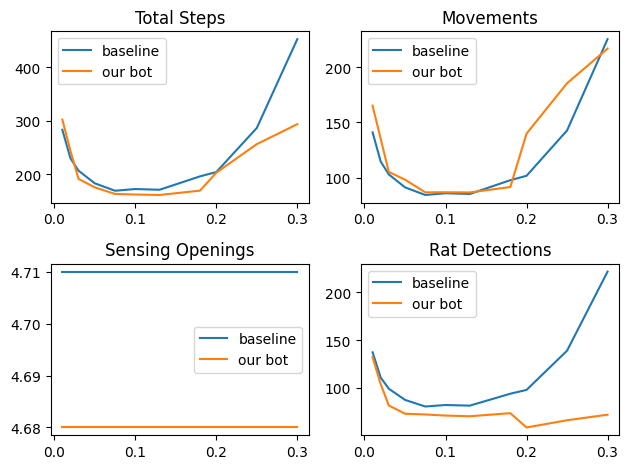

In [ ]:
#GRAPHING THINGS
baseline_move = {alpha:sum(base_res[alpha][0])/len(base_res[alpha][0]) for alpha in alphas}
our_bot_move = {alpha:sum(our_res[alpha][0])/len(our_res[alpha][0]) for alpha in alphas}
baseline_sense = {alpha:sum(base_res[alpha][1])/len(base_res[alpha][0]) for alpha in alphas}
our_bot_sense = {alpha:sum(our_res[alpha][1])/len(our_res[alpha][0]) for alpha in alphas}
baseline_detect = {alpha:sum(base_res[alpha][2])/len(base_res[alpha][0]) for alpha in alphas}
our_bot_detect = {alpha:sum(our_res[alpha][2])/len(our_res[alpha][0]) for alpha in alphas}

baseline_total = {alpha: baseline_move[alpha] + baseline_sense[alpha] + baseline_detect[alpha] for alpha in alphas}
our_bot_total = {alpha: our_bot_move[alpha] + our_bot_sense[alpha] + our_bot_detect[alpha] for alpha in alphas}

plt.subplots(2, 2)
plt.subplot(2,2,1)
plt.plot(baseline_total.keys(),baseline_total.values(),label='baseline')
plt.plot(our_bot_total.keys(),our_bot_total.values(),label='our bot')
plt.title("Total Steps")
plt.legend()
plt.subplot(2,2,2)
# plt.figure()
plt.plot(baseline_move.keys(),baseline_move.values(),label='baseline')
plt.plot(our_bot_move.keys(),our_bot_move.values(),label='our bot')
plt.title("Movements")
plt.legend()
plt.subplot(2,2,3)
# plt.figure()
plt.plot(baseline_sense.keys(),baseline_sense.values(),label='baseline')
plt.plot(our_bot_sense.keys(),our_bot_sense.values(),label='our bot')
plt.title("Sensing Openings")
plt.legend()
plt.subplot(2,2,4)
# plt.figure()
plt.plot(baseline_detect.keys(),baseline_detect.values(),label='baseline')
plt.plot(our_bot_detect.keys(),our_bot_detect.values(),label='our bot')
plt.title("Rat Detections")
plt.legend()
plt.tight_layout()


After running 100 trials for several alphas between 0.01 and 0.3, we can conclude that our bot does in general perform better than the baseline bot. This improvement seems to clearly be stronger at higher alphas. From the graphs, we can see that we rely less on information from the rat detector and instead prioritize moving towards where the rat is likely to be.\
At high alphas, the rat detector is less likely to provide useful information, and so once the bot has a general idea of where the rat is, it is much more helpful to get to that cell and test it than continue to detect at every step.\
At very low alphas, our bot performed slightly worse than baseline. It is likely that our attempt to reduce detections backfired, amounting to the bot moving towards targets it had low confidence in. \
Surprisingly, we see a difference in the sensing openings. This is likely due to luck, in a case where the bot makes it to the rat during phase 1. Since the baseline never detects during phase 1, it continues to search, meanwhile our bot is able to detect that it found the rat in phase 1.

## Question 4, part 1: Updating KB for moving rat

In the case that the rat is moving, we need to change the update formulas to reflect the dynamic probabilities of the rat's location. When before, we simply looked up $P(X_{ij}|S)$ from the knowledge base, this value is now the probability that the rat has *moved into* cell $(i, j)$. We can calculate this by  summing the probability that the rat is in a given cell times the probability the rat moves into $(i, j)$ for all adjacent, open cells. In other words, the probability that the rat is in an adjacent cell divided by the number of possible moves the rat could make from that adjacent cell.
Thus, if $E(i, j)$ is the set of adjacent, open cells to $(i, j)$, then $$P(X_{ij}|S)=\sum_{a\in E(i, j)}\frac{P(X_{a}|S)}{|E(a)|} $$ \

Additionally, we need to update the knowledge base on turns for which the bot doesn't detect. This is because the rat moves on every turn. This is a simple update- no Bayesian formula necessary. We only need to handle the diffusion of probabilities. Thus $$P(X_{ij}|S)=\sum_{a\in E(i, j)}\frac{P(X_{a}|S)}{|E(a)|} $$
is the only calculation we need to make when we update the knowledge base on turns that we don't detect.


## Question 4, part 2: simulation across values of $\alpha$

In [ ]:
alphas = [0.01, 0.02, 0.03, 0.05, 0.075, 0.1, 0.13, 0.18, 0.2, 0.25]
base_res = {alpha:[[], [], []] for alpha in alphas}
our_res = {alpha:[[], [], []] for alpha in alphas}
num_tests = 100
for alpha in alphas:
  print(alpha)
  for i in range(num_tests):
    results = test_baseline(i, False, alpha, True)
    base_res[alpha][0].append(results[0])
    base_res[alpha][1].append(results[1])
    base_res[alpha][2].append(results[2])
    # print(i, "base")

    results = test_our_bot(i, False, alpha, True)
    our_res[alpha][0].append(results[0])
    our_res[alpha][1].append(results[1])
    our_res[alpha][2].append(results[2])
    # print(i, "our bot")


0.01
0.02
0.03
0.05
0.075
0.1
0.13
0.18
0.2
0.25


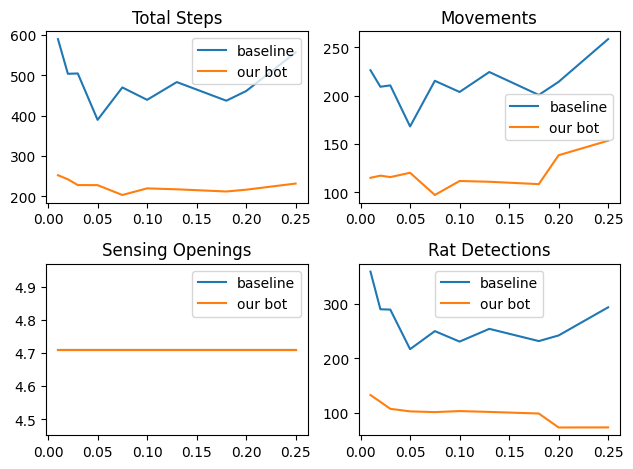

In [ ]:
#GRAPHING THINGS
baseline_move = {alpha:sum(base_res[alpha][0])/len(base_res[alpha][0]) for alpha in alphas}
our_bot_move = {alpha:sum(our_res[alpha][0])/len(our_res[alpha][0]) for alpha in alphas}
baseline_sense = {alpha:sum(base_res[alpha][1])/len(base_res[alpha][0]) for alpha in alphas}
our_bot_sense = {alpha:sum(our_res[alpha][1])/len(our_res[alpha][0]) for alpha in alphas}
baseline_detect = {alpha:sum(base_res[alpha][2])/len(base_res[alpha][0]) for alpha in alphas}
our_bot_detect = {alpha:sum(our_res[alpha][2])/len(our_res[alpha][0]) for alpha in alphas}

baseline_total = {alpha: baseline_move[alpha] + baseline_sense[alpha] + baseline_detect[alpha] for alpha in alphas}
our_bot_total = {alpha: our_bot_move[alpha] + our_bot_sense[alpha] + our_bot_detect[alpha] for alpha in alphas}

plt.subplots(2, 2)
plt.subplot(2,2,1)
plt.plot(baseline_total.keys(),baseline_total.values(),label='baseline')
plt.plot(our_bot_total.keys(),our_bot_total.values(),label='our bot')
plt.title("Total Steps")
plt.legend()
plt.subplot(2,2,2)
# plt.figure()
plt.plot(baseline_move.keys(),baseline_move.values(),label='baseline')
plt.plot(our_bot_move.keys(),our_bot_move.values(),label='our bot')
plt.title("Movements")
plt.legend()
plt.subplot(2,2,3)
# plt.figure()
plt.plot(baseline_sense.keys(),baseline_sense.values(),label='baseline')
plt.plot(our_bot_sense.keys(),our_bot_sense.values(),label='our bot')
plt.title("Sensing Openings")
plt.legend()
plt.subplot(2,2,4)
# plt.figure()
plt.plot(baseline_detect.keys(),baseline_detect.values(),label='baseline')
plt.plot(our_bot_detect.keys(),our_bot_detect.values(),label='our bot')
plt.title("Rat Detections")
plt.legend()
plt.tight_layout()


In the case that the rat is moving, we can see that the baseline bot performs dramatically worse. This is to be expected, as it takes some element of luck for the rat to move into the cell that the bot moves into and then get detected. On the other hand, our bot's performance actually improved slightly, especially in the lower and higher ranges of alpha. For low alphas, we see the strategy of sensing according to confidence in the rat's location work well. We suspect this has to do with the nature of the scenario. When flatly alternating between moving and sensing, the bot needs to move into an adjacent cell to the rat and then the rat has to move into the bot. Because we are not strictly alternating, there are more ways in which the rat might be in the bot's cell when it detects. Thus we improve the endgame strategy of the bot. This is shown in the attached visualizations, which are run on alpha=0.1. Pink is the bot, blue is the rat, yellow is the cell of highest probability, and the rest of the board is colormapped according to probabilities in the knowledge base.

In the high-alpha scenarios, we again see our variance-based strategy paying off, preventing the bot from chasing the most likely cell when it isn't very confident. When the bot gets to the most likely cell, the strategy results in a higher proportion of detections to prevent the rat from passing through undetected.

## Question 4, part 3: Improving our bot when the rat moves

To ensure that our bot was effective in the moving space rat situation, we had to change a few things. First, as already mentioned, we changed *how* we updated the KB, but we also changed *when* we updated the KB. Previously, we only updated the KB when we used the rat detector (because that was the only time we received information to update the KB with). Now, we must update the KB after every action because the rat moves after every action. Basically, we update the KB in two ways: with the results of a ping, and after the rat moves. Updating the KB with the results of the ping is identical to how we update when the rat is not moving, but after every action we also update the KB according to the process described above (the probability of the rat being in any cell is the probability that it moved into that cell from an open neighbor).

When testing our bot for various boards and rat locations, we realized that our bot sometimes got stuck when it was in the location it thought the rat was most likely in, but it didn't have a high enough probability to use the rat detector to determine whether it was in the correct cell. We added a clause to account for this possibility. If the bot is in the cell it thinks the rat is in, it will always use the rat detector. This allows it to either determine that it found the rat or to update the KB and find a new most likely cell.

We tried a few other strategies for our bot to improve in the moving rat scenario, such as moving towards the opposite corner of the board (and detecting every step) until either the bot becomes fairly certain where the rat is or it reaches the corner, and then running our strategy from there. We hoped that this strategy would allow the bot to gain more information on the general location of the rat, but it turned out to be worse in some situations and fail in others, so we abandoned it.

We concluded that our original strategy for our bot, with minor adjustements to account for the fact that the rat was moving, was the most effective strategy.